In [8]:
import os, sys
# os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import numpy as np
import imageio
import pprint
import matplotlib.pyplot as plt
import run_nerf

In [9]:
basedir = './logs'
expname = 'flask_test3'

config = os.path.join(basedir, expname, 'config.txt')
print('Args:')
print(open(config, 'r').read())
parser = run_nerf.config_parser()

args = parser.parse_args('--config {} --ft_path {}'.format(config, os.path.join(basedir, expname, 'model_390000.npy')))
print('loaded args')

H, W, focal = 540, 960, 679.25
hwf = [H, W, focal]

near = 0
far = 1

Args:
expname = flask_test3
basedir = ./logs
datadir = ./data/nerf_synthetic/dex_flask
dataset_type = blender

half_res = True
no_batching = True
lindisp = False
N_samples = 64
N_importance = 64

use_viewdirs = True

white_bkgd = False

N_rand = 1024

render_only = True
render_test = True
loaded args


In [10]:
trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w
camera_angle = 1.2303659303290422

# phi가 -90도 일때, 천장에서 내려다 보고 있는 방향임.  
phi = -60.0
radius = 0.5 # 0 < radius < 1 (카메라부터의 거리)
render_poses = tf.stack([pose_spherical(angle, phi, radius) for angle in np.linspace(0,180,40+1)[:-1]],0)

In [13]:
# Create nerf model
_, render_kwargs_test, start, grad_vars, models = run_nerf.create_nerf(args)

bds_dict = {
    'near' : tf.cast(near, tf.float32),
    'far' : tf.cast(far, tf.float32),
}
render_kwargs_test.update(bds_dict)

print('Render kwargs:')
pprint.pprint(render_kwargs_test)


down = 4
render_kwargs_fast = {k : render_kwargs_test[k] for k in render_kwargs_test}
render_kwargs_fast['N_importance'] = 64
render_kwargs_fast['dex'] = True

# sigma threshold값 변화시키면서 depth map 뽑기 
render_kwargs_fast['sigma'] = 15

MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
MODEL 63 27 <class 'int'> <class 'int'> True
(None, 90) (None, 63) (None, 27)
Not ndc!
Found ckpts ['./logs\\flask_test3\\model_390000.npy']
Reloading from ./logs\flask_test3\model_390000.npy
Resetting step to 390001
Reloading fine from ./logs\flask_test3\model_fine_390000.npy
Render kwargs:
{'N_importance': 64,
 'N_samples': 64,
 'far': <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 'lindisp': False,
 'ndc': False,
 'near': <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 'network_fine': <tensorflow.python.keras.engine.functional.Functional object at 0x0000028029A82AC0>,
 'network_fn': <tensorflow.python.keras.engine.functional.Functional object at 0x0000028029AD1DC0>,
 'network_query_fn': <function create_nerf.<locals>.network_query_fn at 0x0000028025878B80>,
 'perturb': False,
 'raw_noise_std': 0.0,
 'use_viewdirs': True,
 'white_bkgd': False}


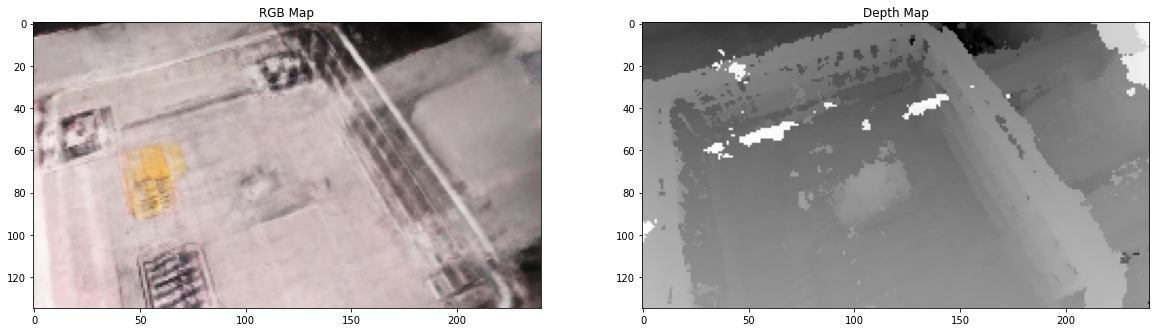

In [12]:
c2w = np.eye(4)[:3,:4].astype(np.float32) # identity pose matrix
test = run_nerf.render(H//down, W//down, focal/down, 1024*32, c2w=render_poses[5, :3, :4],**render_kwargs_fast)
rgb,depth = test[0], -test[1]
plt.figure(figsize = (20, 40))
plt.subplot(1, 2, 1)
plt.title('RGB Map')
plt.imshow(rgb)
plt.subplot(1, 2, 2)
plt.imshow(depth, cmap = 'gray')
plt.title('Depth Map')
plt.show()

In [7]:
down = 4 # trade off resolution+aliasing for render speed to make this video faster
frames_depth = []
frames_rgb = []
for i, c2w in enumerate(render_poses):
    if i%8==0: print(i)
    test = run_nerf.render(H//down, W//down, focal/down, c2w=c2w[:3,:4], **render_kwargs_fast)
    frames_depth.append( - (255*np.clip(test[1],0,1)).astype(np.uint8))
    frames_rgb.append((255*np.clip(test[0],0,1)).astype(np.uint8))
    
print('done, saving')
f = './video_test_depth.mp4'
imageio.mimwrite(f, frames_depth, fps=10, quality=8)
g = './video_test_rgb.mp4'
imageio.mimwrite(g, frames_rgb, fps=10, quality=8)

from IPython.display import Video
Video(f, height=320)

0
8
16
24
32


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (240, 135) to (240, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


done, saving


IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (240, 135) to (240, 144) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
